In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import optimize
from scipy import signal
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [709]:
def get_num_baselines(Nside):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*Nside**2 - 2*Nside
    return int(N_bases)

rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)
zero_weight = lambda x, d: x/d if d else 0

def make_gains(Nside):
    # Create complex gains with either (amplitude, phase) or (real, imaginary)
    Nant = Nside**2
    gain_amp = np.random.normal(1, .05, Nant)
    gain_phase = rand_phases(Nant)
    tgain = gain_amp*np.exp(1j*gain_phase)    
    return tgain

def make_data(Nside, gains, noise=0.1):
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    vis_true = np.random.normal(0,1,size=(Nbase,2)).view(np.complex128).flatten() ## size of unique baselines
    ant_i, ant_j, visndx, data = [], [], [], []
    ndx=0
    ndx2base={}
    base2ndx={}
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside,Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside,Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            if baseline in base2ndx:
                cndx = base2ndx[baseline]
            else:
                cndx = ndx
                base2ndx[baseline]=ndx
                ndx2base[ndx]=baseline
                ndx+=1
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(cndx)
            data.append(vis_true[cndx]*gains[i]*np.conj(gains[j]))
            
    assert(ndx==Nbase)
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx

In [728]:
def make_uv_grid(Nside):
    uv_size = Nside*2 - 1
    center = (Nside-1,Nside-1)
    npcenter = np.array(center)
    random_uv_grid = np.zeros((uv_size, uv_size, 2)).view(np.complex128)
    poss_uv = random_uv_grid.reshape((uv_size, uv_size))
    
    # Bottom right and top left should be conjugates
    for i in range(Nside-1, uv_size):
        for j in range(Nside, uv_size):
            rel_to_center = np.array([i,j]) - npcenter
            conj_pos = tuple(npcenter - rel_to_center)
            visb = np.random.normal(0,1,2).view(np.complex128)
            poss_uv[i,j] = visb
            poss_uv[conj_pos] = np.conj(visb)
    
    # Top right and bottom left should be conjugates
    for i in range(Nside, uv_size):
        for j in range(0, Nside):
            rel_to_center = np.array([i,j]) - npcenter
            conj_pos = tuple(npcenter - rel_to_center)
            visb = np.random.normal(0,1,2).view(np.complex128)
            poss_uv[i,j] = visb
            poss_uv[conj_pos] = np.conj(visb)
            
    poss_uv[center] = 0
    return poss_uv, npcenter

In [842]:
def make_data_grid(Nside, gains, noise=0.1, beamsize=1):
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    uv_grid, npcenter = make_uv_grid(Nside)
    beam1_f = np.ones((beamsize, beamsize), dtype=np.complex128)
    conv_beam = signal.fftconvolve(beam1_f, beam1_f)
    vis_true = np.zeros(Nbase, dtype=np.complex128)
    ant_i, ant_j, visndx, data = [], [], [], []
    ndx=0
    ndx2base={}
    base2ndx={}
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside,Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside,Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            if baseline in base2ndx:
                cndx = base2ndx[baseline]
            else:
                cndx = ndx
                base2ndx[baseline]=ndx
                ndx2base[ndx]=baseline
                ndx+=1
            uv_point = uv_grid[tuple(npcenter + baseline)]
            vis_true[cndx] = np.sum(signal.fftconvolve([[uv_point]], conv_beam))
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(cndx)
            data.append(vis_true[cndx]*gains[i]*np.conj(gains[j]))
            
    assert(ndx==Nbase)
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx

In [843]:
def make_pred(gains, vis, ant_i, ant_j, visndx):
    gains_i = gains[ant_i]
    cgains_j = np.conj(gains[ant_j])
    pred = gains_i*cgains_j*vis[visndx]
    return pred

In [844]:
def chi2 (data, gains, vis, ant_i, ant_j, visndx, noise=0.1):
    pred = make_pred(gains, vis, ant_i, ant_j, visndx)
    chi2 = np.abs((data - pred)**2).sum()/(noise**2)
    dof = len(data)*2
    return chi2, dof

In [845]:
def flat_to_matrix(Nside, flattened, a_i, a_j):
    Nant = Nside**2
    temp_mat = np.zeros((Nant, Nant), dtype=np.complex128)
    temp_mat[a_i, a_j] = flattened
    temp_mat[a_j, a_i] = np.conj(flattened)
    return temp_mat

In [846]:
Nside = 5
Nant = Nside * Nside
Nbase = get_num_baselines(Nside)
uv_size = Nside*2 - 1
gains_true = make_gains(Nside)
# uv_grid, npcenter = make_uv_grid(Nside)
# vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx = make_data(Nside, gains_true)
vis_true, data, ant_i, ant_j, visndx, ndx2base, base2ndx = make_data_grid(Nside, gains_true, noise=0)
data_len = len(data)

In [847]:
no_noise = make_pred(gains_true, vis_true, ant_i, ant_j, visndx)

In [746]:
phased_gains = gains_true*np.exp(1j*rand_phases(Nant)/5)

In [699]:
chi2(data, gains_true, vis_true, ant_i, ant_j, visndx)

(613.0047187661785, 600)

In [700]:
baseline2 = npcenter + (0,2)
baseline3 = npcenter + (0,3)

In [701]:
baseline2

array([4, 6])

In [926]:
beam1_f = np.ones((3,3))

In [937]:
grab_3uv = np.zeros((3,3), dtype=np.complex128)

In [938]:
for i in [3,4,5]:
    for j in [5,6,7]:
        grab_3uv[i-3,j-5] = uv_grid[i,j]

In [940]:
grab_3uv[1,1]

(0.19765512423766743-0.48898071952988936j)

In [870]:
sing_point = uv_grid[4,6]

In [942]:
conv_beam = signal.fftconvolve(beam1_f, beam1_f)

In [946]:
lhs = signal.fftconvolve(grab_3uv, beam1_f)

In [949]:
lhs[2,2]

(-4.079811762937811+3.731105990818185j)

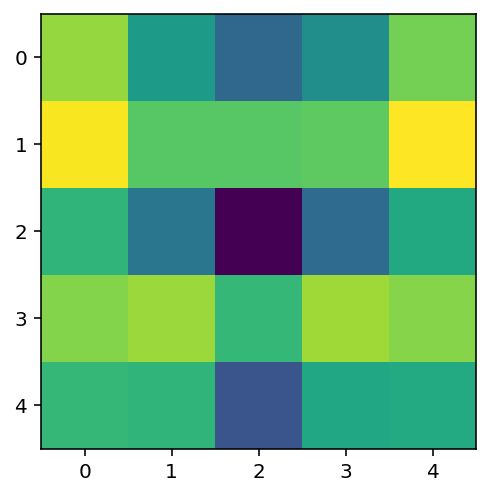

In [947]:
plt.imshow(conv_beam.real)

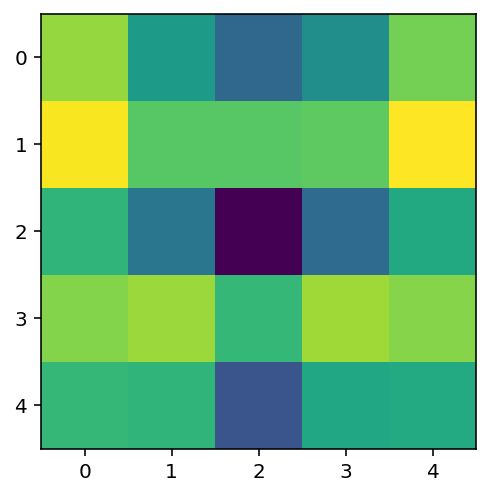

In [948]:
plt.imshow(lhs.real)

In [791]:
test_image = np.random.normal(0,1,(uv_size, uv_size,2)).view(np.complex128)

In [793]:
test_image = test_image.reshape((uv_size, uv_size))

In [794]:
testf = np.fft.fft2(test_image)

In [795]:
testf[3,0]

(-12.66776987239776+5.101876807163893j)

In [796]:
testf[0,0]

(-11.19416013955638-15.224746300962256j)

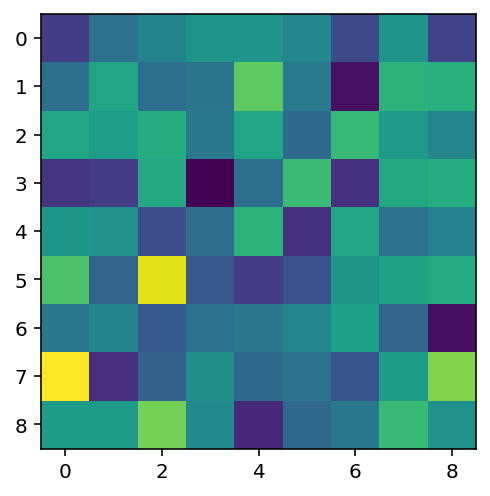

In [797]:
plt.imshow(testf.real)

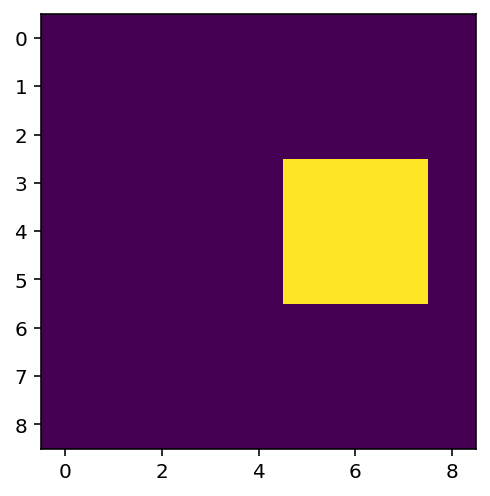

In [225]:
plt.imshow(a)